In [54]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Постановка
Разработать модель, позволяющую на основе задаваемых пользователем значений признаков, построить предварительную оценку стоимости квартиры.

ЗАДАЧИ
1. Очистить данные
2. Построить гипотезы о параметрах модели
3. Проверить с обучением и валидацией
4. Создать новый алгоритм или изменить параметры старой модели

1. Выбрать параметр оптимизации модели
2. Подать алгоритму данные и модель
3. Повторить процесс

Лучшую модель обернуть в сервис или контейнер

Модели
  метод LinearRegression — линейная регрессия, 
  GradientBoostingRegressor — градиентный бустинг.


ЭТАПЫ
1. Выполнить предобработку данных (preprocessing):
  Очистка данных
  Анализ и удаление выбросов
  Анализ и восстановление пропусков
  Стандартизация данных
  Выделение характерных признаков  
2. Выполнить вычисления по модели многомерной линейной регрессии и провести анализ полученной модели:
  Оценить качество регрессии по коэффициенту детерминации
  Оценить ошибку RMSE
  Выделить значимые и незначимые коэффициенты регрессии 

Посмотрим на датасет и проведем очистку данных


In [2]:
df=pd.read_csv('data.csv')

In [3]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


удаляем дубли

In [3]:
df.drop_duplicates(inplace = True)
df=df.reset_index(drop=True)

In [60]:

df.info()

#Смотрим на датасет и очень опечалены, чистых числовых столбцов нет, на входе только замусоренные столбцы. 
#На данном этапе работы складывается ощущение, что до модели дело не дойдет, нужно много времени на очистку данных.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377135 entries, 0 to 377134
Data columns (total 18 columns):
status          337218 non-null object
private pool    4181 non-null object
propertyType    342402 non-null object
street          377133 non-null object
baths           270827 non-null object
homeFacts       377135 non-null object
fireplace       103112 non-null object
city            377101 non-null object
schools         377135 non-null object
sqft            336585 non-null object
zipcode         377135 non-null object
beds            285881 non-null object
state           377135 non-null object
stories         226462 non-null object
mls-id          24942 non-null object
PrivatePool     40310 non-null object
MlsId           310266 non-null object
target          374655 non-null object
dtypes: object(18)
memory usage: 51.8+ MB


In [6]:
# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)
# 
# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

[]
['status' 'private pool' 'propertyType' 'street' 'baths' 'homeFacts'
 'fireplace' 'city' 'schools' 'sqft' 'zipcode' 'beds' 'state' 'stories'
 'mls-id' 'PrivatePool' 'MlsId' 'target']


визуализация пропущенных значений с помощью тепловой карты

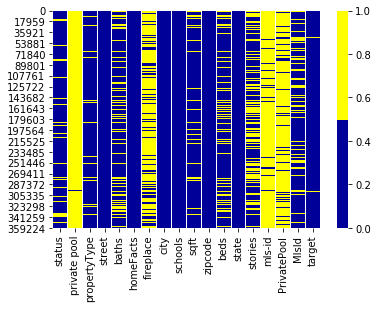

In [7]:
#Смотрим много ли пропусков в этих мусорных данных 
cols = df.columns
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

список долей отсутствующих записей для каждого признака

In [8]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
    
#Видим, что данные из столбцов private pool - 99.0% и PrivatePool - 89.0% содержат много пропусков. Можно их сразу удалить
#или заполнить пустые строки 0.
#Аналогично с fireplace - 73.0%. Данные из полей MlsId и mls-id можно слить в один и получится хорошая заполненность.
#В остальных данных пропусков не так много.



status - 11.0%
private pool - 99.0%
propertyType - 9.0%
street - 0.0%
baths - 28.0%
homeFacts - 0.0%
fireplace - 73.0%
city - 0.0%
schools - 0.0%
sqft - 11.0%
zipcode - 0.0%
beds - 24.0%
state - 0.0%
stories - 40.0%
mls-id - 93.0%
PrivatePool - 89.0%
MlsId - 18.0%
target - 1.0%


Начинаем обработку с target. Удалим строки, в которых не задана цена, проведем преобразование столбца к числовому типу

TARGET


In [4]:
df['target_new'] = pd.to_numeric(df['target'].str.replace('\D', ''), errors='coerce')
df = df[~df['target_new'].isnull()]
#df.drop(['target'], axis='columns', inplace=True)

In [62]:
# удаляем исходный столбец, оставляем только преобразованный числовой  
df.drop(['target'], axis='columns', inplace=True)

In [7]:
df.target_new.value_counts(normalize='true')

225000.0    0.004820
275000.0    0.004404
250000.0    0.004388
350000.0    0.004380
325000.0    0.004169
              ...   
420080.0    0.000003
9100.0      0.000003
515530.0    0.000003
195050.0    0.000003
374521.0    0.000003
Name: target_new, Length: 34232, dtype: float64

In [8]:
df.target_new.describe()

count    3.746550e+05
mean     6.447596e+05
std      1.841482e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.820000e+05
max      1.950000e+08
Name: target_new, dtype: float64

STATUS

оставим записи с теми статусами, где больше всего записей. ТОП-8

In [5]:
df['status_new'] = df['status'].str.lower()
df['status_new'].fillna('not detect', inplace = True) 
df.loc[df['status_new'].str.contains('sold')==True,'status_new']='sold'
df.loc[df['status_new'].str.contains('pending')==True,'status_new']='pending'
df.loc[df['status_new'].str.contains('coming')==True,'status_new']='coming'
df.loc[df['status_new'].str.contains('under contract')==True,'status_new']='contract'
df.loc[df['status_new'].str.contains('contract')==True,'status_new']='contract'
df.loc[df['status_new'].str.contains('auction')==True,'status_new']='auction'
df.loc[df['status_new'].str.contains('foreclosure')==True,'status_new']='foreclosure'
status_list = df['status_new'].value_counts()[:8].index
df = df[df['status_new'].isin(status_list)]
df=df.reset_index(drop=True)

In [7]:
df['status_new'].value_counts()

for sale            199520
active              105206
not detect           39256
foreclosure           8022
new construction      5458
pending               5359
contract              3802
auction               2611
Name: status_new, dtype: int64

In [143]:
#df.drop(['status_new'], axis='columns', inplace=True)
#df.drop(['status'], axis='columns', inplace=True)

PRIVATEPOOL

соединим данные из двух столбцов и приведем к числовому типу

In [6]:
df['PrivatePool'].fillna('no',inplace=True)
df['private pool'].fillna('no',inplace=True)
df['PrivatePool'] = df['PrivatePool'].str.lower()
df['private pool'] = df['private pool'].str.lower()
level_map = {'yes': 1, 'no': 0}
df['PrivatePool'] = df['PrivatePool'].map(level_map)
df['private pool'] = df['private pool'].map(level_map)
df['pool_new'] = df[['PrivatePool','private pool']].max(axis =1)

In [9]:
df['pool_new'].value_counts(normalize=True)

0    0.880442
1    0.119558
Name: pool_new, dtype: float64

In [10]:
df.drop(['private pool'], axis='columns', inplace=True)
df.drop(['PrivatePool'], axis='columns', inplace=True)

PROPERTYTYPE

In [7]:
#заменим совпадающие категории одним названием
df['propertyType_new'] = df['propertyType'].str.lower()
df.loc[(df['propertyType_new'].str.contains('family')|df['propertyType'].str.contains('single')),'propertyType_new']='single_family'


In [41]:
df['propertyType_new'].value_counts()

single_family                                       204288
condo                                                44678
lot/land                                             22765
townhouse                                            19323
condo/townhome/row home/co-op                         7899
                                                     ...  
bungalow, craftsman, ranch                               1
mediterranean, other style, spanish, traditional         1
bungalow, craftsman, traditional                         1
craftsman, colonial, traditional                         1
other - see remarks                                      1
Name: propertyType_new, Length: 1228, dtype: int64

In [123]:
#df.drop(['propertyType_new'], axis='columns', inplace=True)
#df.drop(['propertyType'], axis='columns', inplace=True)

STREET

необходимо преобразовать в какую-то новую feature, пересчитав в расстояние до ценра или что-то подобное
Пока просто удаляем

In [16]:
#если будет время можно попробовать преобразовать в расстояние до центра
#df['street'].value_counts()
df.drop(['street'], axis='columns', inplace=True)

BATHS

преобразуем к числовому формату

In [8]:
df['baths_new'] = pd.to_numeric(df['baths'].str.replace('\D\.', ''), errors='coerce')


In [9]:
df.drop(['baths'], axis='columns', inplace=True)

In [19]:
df.baths_new.value_counts()

2.0      35797
3.0      20571
1.0      11847
4.0       8070
2.5       7480
0.0       3845
3.5       3340
5.0       2753
1.5       1603
6.0       1237
4.5        986
7.0        663
8.0        391
5.5        307
750.0      237
9.0        178
10.0       109
6.5        106
11.0        70
12.0        35
7.5         31
13.0        22
16.0        17
14.0        16
18.0        13
8.5         12
15.0        10
24.0         6
22.0         4
9.5          4
23.0         4
17.0         4
10.5         3
30.0         3
20.0         3
21.0         2
40.0         2
12.5         2
26.0         2
27.0         2
41.0         1
29.0         1
32.0         1
44.0         1
64.0         1
35.0         1
34.0         1
55.0         1
Name: baths_new, dtype: int64

In [9]:
#определим выбросы
def z_score(ys, treshold=3):
    mean_y=np.mean(ys)
    std_y=np.std(ys)
    z_scores=[(y-mean_y)/std_y for y in ys]
    return np.where(np.abs(z_scores)>treshold)[0]#with warnings.caths_warnings():
#    warnings.simplefilter('ignore')
o=z_score(df['baths_new'])
len(o)
#удаляем строки, где больше 6 ванн
df = df.drop(df[df.baths_new>6.0].index)#В завершение заполним пропуски средним значением по столбцу
df=df.reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [10]:
df['baths_new'].fillna(df['baths_new'].mean(),inplace=True)

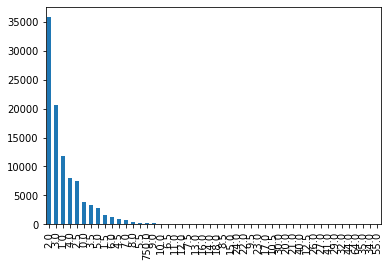

In [210]:
df['baths_new'].value_counts().plot.bar()

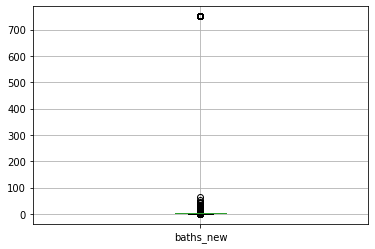

In [211]:
%matplotlib inline
df.boxplot(column=['baths_new'])

In [215]:
df['baths_new'].describe()
#видно, что максимальное значение равно 750,
#в то время как 75% квартиль равен только 43. Значение 750 – выброс.

count    367275.000000
mean          2.427951
std           0.586738
min           0.000000
25%           2.427951
50%           2.427951
75%           2.427951
max           6.000000
Name: baths_new, dtype: float64

FIREPLASE

In [11]:
df['fireplace_new'] = df['fireplace'].str.lower()
df.loc[df['fireplace_new'].str.contains('fireplace')==True, 'fireplace_new'] = 1
df.loc[df['fireplace_new'].str.contains('not applicable')==True, 'fireplace_new'] = 0
df.loc[df['fireplace_new'].str.contains('yes')==True, 'fireplace_new'] = 1
df['fireplace_new'] = df['fireplace_new'].apply(pd.to_numeric, errors='coerce')
df['fireplace_new'].fillna(0, inplace = True) 
#df.drop(['fireplace'], axis='columns', inplace=True)

In [18]:
df['fireplace_new'].value_counts(normalize=True)

0.0     0.758138
1.0     0.233849
2.0     0.005805
3.0     0.001402
4.0     0.000468
5.0     0.000172
6.0     0.000087
7.0     0.000044
8.0     0.000014
10.0    0.000008
11.0    0.000005
9.0     0.000005
12.0    0.000003
Name: fireplace_new, dtype: float64

In [12]:
#удалим выбросы
df = df.drop(df[df.fireplace_new>5].index)
df=df.reset_index(drop=True)

In [25]:
df.drop(['fireplace'], axis='columns', inplace=True)

BEDS

In [13]:
#!!!! выбросы тоже заменить на самое частое значение
#данные в акрах и квадратах заменим на среднее значение, возможно лучше их будет удалить.
df['beds_new'] = df['beds'].str.lower()
df.loc[df['beds_new'].str.contains('sqft')==True, 'beds_new'] = np.NaN
df.loc[df['beds_new'].str.contains('acres')==True, 'beds_new'] = np.NaN
df['beds_new'] = pd.to_numeric(df['beds'].str.replace('\D\.', ''), errors='coerce')


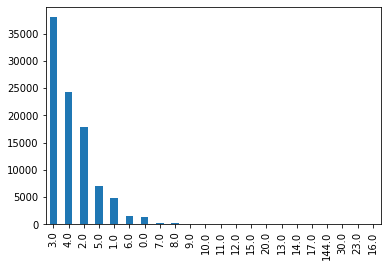

In [221]:
df['beds_new'].value_counts().plot.bar()

In [14]:
df = df.drop(df[df.beds_new>7].index)
df=df.reset_index(drop=True)

In [15]:
df['beds_new'].fillna(df['beds_new'].mean(),inplace=True)

In [23]:
df['beds_new'].value_counts()

3.12977    271467
3.00000     38016
4.00000     24245
2.00000     17918
5.00000      7093
1.00000      4874
6.00000      1547
0.00000      1416
7.00000       306
Name: beds_new, dtype: int64

In [30]:
df.drop(['beds'], axis='columns', inplace=True)

SCHOOLS

из поля schools берем списки школ и на их основе формируем столбецы с количеством школ поблизости, расстоянием до ближайшей, расстояние до дальней (дальняя вряд ли нужна). 
Если останется время, то нужно вернуться к обработке и на основе этого поля лучше попробовать сформировать столбец с расстоянием до школы с самым высоким рейтингом.

In [16]:
#попробовать выделить расстояние до школы
def check_schools(x):
    x = eval(x)
    distance_list = (x[0]['data']['Distance'])
    #print(str(x[0]['data']['Distance']).replace('mi','').split(',').astype(float))
    new_list=[]
    for i in distance_list:
        str_not_mi = i.replace('mi',"")
       
        new_list.append(float(str_not_mi))
    return new_list
   
#df['count_school'] = df['schools'].apply(split_schools)
df['list_school'] = df['schools'].apply(check_schools)
df['count_school'] = df['list_school'].apply(lambda x: len(x))
df['min_school_dist'] = df['list_school'].apply(lambda x: 0 if len(x)==0 else min(x))
df['max_school_dist'] = df['list_school'].apply(lambda x: 0 if len(x)==0 else max(x))
df.drop(['list_school'], axis='columns', inplace=True)

In [228]:
df[(df['count_school'].isnull())]

,status,private pool,propertyType,homeFacts,city,schools,sqft,zipcode,state,stories,...,target_new,status_new,pool_new,propertyType_new,baths_new,fireplace_new,beds_new,count_school,min_school_dist,max_school_dist


In [64]:
df['count_school'].value_counts()

3     203120
2      34429
8      31435
5      28221
4      21774
6       8969
1       8457
7       5116
0       3207
24      2063
22      1783
13      1058
12       869
10       770
63       764
11       751
9        539
15       517
14       435
65       353
49       278
61       128
16       119
21        96
17        11
26        10
19         3
Name: count_school, dtype: int64

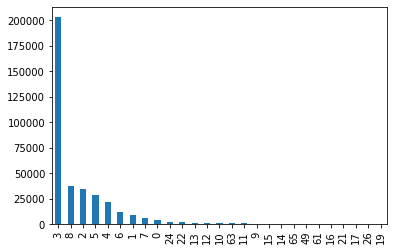

In [231]:
df['count_school'].value_counts().plot.bar()

SQFT

Чистим столбец с площадью

In [56]:
df['sqft'].isnull().value_counts(normalize='true')

False    0.891864
True     0.108136
Name: sqft, dtype: float64

In [17]:
df['sqft_new'] =pd.to_numeric(df['sqft'].str.replace('\D', ''), errors='coerce')

In [18]:
df = df.drop(df[df.sqft_new==0].index)
df=df.reset_index(drop=True)

In [19]:
#11% пустых значений, заменим их на среднее
df['sqft_new'].isnull().value_counts(normalize='true')
df['sqft_new'].fillna(df['sqft_new'].mean(),inplace=True)


In [21]:
df['sqft_new'].isnull().value_counts(normalize='true')

False    1.0
Name: sqft_new, dtype: float64

MLSID

In [154]:
#пока не используем, просто удалим эти столбцы.
#В регрессию мы его не сможем использовать, в идентификторах есть символы

def merge_mslid(row):
    if pd.isnull(row['MlsId'])==False:
        return row['MlsId']
    if pd.isnull(row['mls-id'])==False:
        return row['mls-id']
    return 0
    # Применяем функцию  
new_mlsid = df.apply(lambda row: merge_mslid(row), axis = 1)  
df['MlsId'] = new_mlsid

#df['d'] = np.where(df.c > df.b, 'Type a', 'Type b')

In [22]:
df.drop(['mls-id'], axis='columns', inplace=True)
df.drop(['MlsId'], axis='columns', inplace=True)

HOMEFACTS

попробуем распарсить этот словарь и поместить данные в новые столбцы

In [ ]:
#ооочень долгое выполнение, пропустим. Будем использовать другой вариант
def split_homeFacts(row):
    #split_res =[]
    #columns=[]
    x = eval(row['homeFacts'])
    v_dict_list = x.get("atAGlanceFacts")
    for one_dict in v_dict_list:
        for key, values in one_dict.items():
            if key == 'factValue':
                val_write=values
                #split_res.append(values)
            if key == 'factLabel':
                key_write = values
           
        row[key_write]=val_write
    
    #SplitString = ','.join(map(str,split_res))  
    #print(SplitString)
    return #split_res
    # Применяем функцию  
#df_new = df.loc[3].apply(lambda row:split_homeFacts(row),axis =1)
df = df.apply(lambda row:split_homeFacts(row),axis =1)
#df_new = pd.DataFrame.from_records(df['home_new'])
#df['split_res'] = df['homeFacts'].apply(split_homeFacts)
#df['split_res'] = df.apply(lambda row:split_homeFacts(row),axis =1)
#df[['Year_built','Remodeled_year','Heating','Cooling','Parking','lotsize','Price_sqft']]=str(df['split_res']).split(',')
#df[['Year_built']]=df['split_res'].str.split(',', expand=True)

Добавляем новые факты о домах и будем последовательно приводить их к числовому формату

In [20]:
#данные из словаря добавляем как отдельные столбцы, по каждому ключу
v_len = df["homeFacts"][0:1].apply(lambda x: len(eval(x)["atAGlanceFacts"]))[0]
for i in range(v_len):
    var = 'home_fact_'+str(i)
    df[var] = df["homeFacts"].apply(lambda x: eval(x)["atAGlanceFacts"][i].get('factValue'))


In [240]:
df

0         None
1         None
2         None
3         None
4         None
          ... 
377180    None
377181    None
377182    None
377183    None
377184    None
Length: 366882, dtype: object

на основании года постройки определяем возраст дома в новый столбец (home_fact_0 == Year built )

In [23]:
#не выполнять!
#возраст дома вводить не будем, оставим год
df['year_old'] = 2020 - pd.to_numeric(df['home_fact_0'], errors='coerce') 
df.loc[(df['year_old']<-6),'year_old']=df['year_old'].value_counts().index[0]
df['year_old'].fillna(df['year_old'].value_counts().index[0],inplace=True)


In [21]:
df['year_old'] = pd.to_numeric(df['home_fact_0'], errors='coerce') 
df.loc[(df['year_old']>2026)|(df['year_old']<1800),'year_old']=np.NaN
df['year_old'].fillna(df['year_old'].mean(),inplace=True)
df.year_old=df['year_old'].apply(lambda x:round(x,0))

число лет с момента реконструкции (home_fact_1 == Remodeled year)

In [22]:
df['reconstruct_old'] = pd.to_numeric(df['home_fact_1'], errors='coerce') 
df.loc[(df['reconstruct_old']<1800),'reconstruct_old']=np.NaN
df['reconstruct_old'].fillna(df['reconstruct_old'].mean(),inplace=True)
df.reconstruct_old=df['reconstruct_old'].apply(lambda x:round(x,0))

обозначаем наличие обогрева (home_fact_2 ==Heating)

In [23]:
df['heating'] = df['home_fact_2'].str.lower()
df.loc[(df['heating']==''),'heating']='other_heating'
df.loc[(df['heating'].str.contains('central')==True)&(df['heating'].str.contains('air')==True),'heating']='central_air'
df.loc[(df['heating'].str.contains('electric')==True),'heating']='electric'
df.loc[(df['heating'].str.contains('other')==True),'heating']='other_heating'
df['heating'].fillna('other',inplace=True)

обозначаем наличие кондиционера home_fact_3 ==Cooling
Пока не будем добавлять данные из этого поля, ограничимся данными из предыдущего столбца
!!!Если останется время, то нужна агрегация данных по этим двум столбцам

In [277]:
df['cooling'] = df['home_fact_3'].str.lower()

In [279]:
df['cooling'] .value_counts()

central                                                                                   155739
                                                                                          115756
central air                                                                                13803
no data                                                                                    10225
has cooling                                                                                 9660
                                                                                           ...  
forced air heating, 90%+ high efficiency, hot water recirc pump, tankless water heater         1
window unit heating, 2 units                                                                   1
central air, gas (hot air), wall-unit a/c, woodstove                                           1
central air, electric, gas, energy star qualified equipment, high efficiency                   1
hot water recirc pump         

In [135]:
df['cooling'] =df['cooling'].str.replace('\d', '')
df.loc[df['cooling'].str.contains('central')==True, 'cooling'] = 'central'
df.loc[df['cooling'].str.contains('has cooling')==True, 'cooling'] = 'central'
df.loc[df['cooling'].str.contains('no data')==True, 'cooling'] = 'no_data'
df['cooling'].fillna('no_data',inplace=True)

In [ ]:
cooling_with_freqs = list(df.cooling.value_counts())
top_cooling_count = int(np.percentile(cooling_with_freqs, 90))
top_cooling_count

all_cooling = df.cooling.value_counts().index
top_cooling = list(all_cooling)[:top_cooling_count]
cooling_to_throw_away = list(set(all_cooling) - set(top_cooling))
df.loc[df['cooling'].isin(cooling_to_throw_away),'cooling'] = 'other'
len(df.cooling.value_counts())

pd.get_dummies(df.cooling, drop_first=True).head()



обозначим наличие паркинга (home_fact_4 ==Parking)

In [285]:
df['parking'] = df['home_fact_4'].str.lower()

In [291]:
#слишком много значений, заполненных пробелом. Пока не будем включать это поле в анализ, позже, если останется время
df[(df['parking']=='')]['parking'].count()

165482

In [292]:
#df.drop(['parking'], axis='columns', inplace=True)
#df.drop(['home_fact_4'], axis='columns', inplace=True)

home_fact_5 ==lotsize

In [29]:
#площадь территории
df['lotsize'] = df['home_fact_5'].str.lower()

In [30]:
#смотрим на предмет выбросов и специфических значений
#слишком мало информативных данных, не будем брать этот столбец в рассмотрение
df['lotsize'].value_counts()

                 32413
—                24616
no data           5270
-- sqft lot       3810
0.26 acres        3076
                 ...  
65684                1
5218                 1
5.5 acres lot        1
6830 sqft            1
64468 sqft           1
Name: lotsize, Length: 35963, dtype: int64

In [168]:
df['lotsize'] =pd.to_numeric(df['home_fact_5'].str.replace('\D', ''), errors='coerce')


In [ ]:
#удаляем выбросы

In [166]:
df['lotsize'].fillna(df['lotsize'].mean(),inplace=True)

In [ ]:
df.drop(['home_fact_5'], axis='columns', inplace=True)

home_fact_6 ==Price/sqft

In [174]:
#не берем это поле в рассмотрение, т.к. у нас в данных есть площадь и цена объекта.
df['price_sqft'] =pd.to_numeric(df['home_fact_6'].str.replace('\D', ''), errors='coerce')
df['price_sqft'].fillna(df['price_sqft'].value_counts().index[0],inplace=True)

In [298]:
df.drop(['home_fact_6'], axis='columns', inplace=True)

STORIES

In [24]:
#STORIES
#Проанализируем этажность
#Заменяем слова на цифры 
#Заменим слова, содержащие значения цифр, на сами цифры
df['stories_new'] = df['stories'].str.lower()
df['stories_new'].fillna('not detect', inplace = True)
df.loc[(df['stories_new'].str.contains('one[\D]*')==True),'stories_new']=int(1)
df.loc[df.stories_new.str.contains('two[\D]*') | df.stories_new.str.contains('duplex[\D]*'),'stories_new']=int(2)
df.loc[df.stories_new.str.contains('three[\D]*')| df.stories_new.str.contains('triplex[\D]*') | df.stories_new.str.contains('tri[\D]*'),'stories_new']=int(3)#Остальные слова, за исключением цифровых значений, удалим. 
#Удалять надо аккуратно, если стереть точки и запятые, "30.00" превратится в "3000"
df.stories_new=df.stories_new.str.replace('[^0-9\,\.]*', '')
df.stories_new=df.stories_new.str.replace('[\,]', '.')
df.stories_new=df.stories_new.str.replace('\.\.', '')
df.stories_new=df.stories_new.str.replace('1.5.', '1.5')#Приведем строку к числовому формату
df['stories_new'] = pd.to_numeric(df['stories_new'], errors='coerce')#Удалим нелогичные данные: дом должен содержать хотя бы 1 этаж, небоскреб более 100 этажей также исключительное явление
df = df.drop(df[df.stories_new>100].index)
df = df.drop(df[df.stories_new==0].index)#Округлим полученные значения 
df.stories=df['stories_new'].apply(lambda x:round(x,0))
df=df.reset_index(drop=True)

In [56]:
#посмотреть на данные и понять, что имелось ввиду с этим 0, может частные дома?
df[(df['stories_new']==2)]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,stories_new
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000",2.0
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,NaN,NaN,PAPH847006,"$209,000",2.0
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,NaN,NaN,73968331,"$311,995",2.0
11,Active,NaN,English,4222 False Cypress Ln,NaN,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Houston,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...","3,130",77068,NaN,TX,2.0,NaN,NaN,5741322,"260,000",2.0
14,NaN,NaN,Single Family,15351 Falmouth Ave,3,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",NaN,Houston,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...","2,454",77084,4,TX,2.0,NaN,NaN,65299510,"$168,800",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365646,NaN,NaN,Single Family,3540 Palmetto Ave,3.0,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","1,740",33133,3,FL,2.0,NaN,Yes,A10591679,"$1,450,000",2.0
365650,For sale,NaN,Single Family,6121 Darby Ave,3,"{'atAGlanceFacts': [{'factValue': '1977', 'fac...",Yes,Las Vegas,"[{'rating': ['5/10', '4/10', '3/10'], 'data': ...","2,672",89146,3,NV,2.0,NaN,Yes,2152007,"$499,999",2.0
365653,for sale,NaN,single-family home,19743 N Sagamore Rd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",yes,Fairview Park,"[{'rating': ['6/10', '5/10', '6/10'], 'data': ...","2,505 sqft",44126,5 Beds,OH,2.0,NaN,NaN,4126112,"$384,900",2.0
365655,for sale,NaN,single-family home,9711 Lawngate Dr,3 Baths,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",yes,Houston,"[{'rating': ['2/10', '3/10', '3/10'], 'data': ...","1,792 sqft",77080,4 Beds,TX,2.0,NaN,NaN,74136719,"$280,000",2.0


CITY

In [ ]:
пока не придумалось, как маппировать города в числа - не используем 

In [84]:
df.drop(['city'], axis='columns', inplace=True)

In [ ]:
#вариант преобразования в дамми - переменные дает дополнительно сотни столбцов...

In [306]:
#Не выполнять
cities_with_freqs = list(df.city.value_counts())
top_cities_count = int(np.percentile(cities_with_freqs, 90))
top_cities_count

272

In [125]:
#пропускаем
all_cities = df.city.value_counts().index
top_cities = list(all_cities)[:top_cities_count]
cities_to_throw_away = list(set(all_cities) - set(top_cities))
df.loc[df['city'].isin(cities_to_throw_away),'city'] = 'other'
len(df.city.value_counts())

pd.get_dummies(df.city, drop_first=True).head()

AttributeError: 'DataFrame' object has no attribute 'city'

STATE

преобразуем в dummy-переменную

In [25]:
#преобразуем столбец в dummy-переменные
df_state = pd.get_dummies(df.state, drop_first=True)#.head()

In [30]:
df.state.value_counts()

FL    103357
TX     80305
NY     23006
NC     19801
CA     19734
TN     16876
WA     11533
OH     10955
NV      8318
IL      8106
GA      6040
CO      5864
PA      5349
MI      4713
DC      4380
AZ      3223
IN      2737
OR      2722
MA      1443
UT      1250
MD      1057
VT       709
MO       700
VA       636
WI       382
NJ       359
IA       202
ME       188
KY        68
OK        30
SC        27
MS        26
DE         5
MT         3
BA         1
OT         1
Fl         1
OS         1
Name: state, dtype: int64

In [53]:
df_state

,BA,CA,CO,DC,DE,FL,Fl,GA,IA,IL,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344103,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
344104,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
344105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
344106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
df = df.join(df_state).ffill()

In [27]:
df.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target',
       'target_new', 'status_new', 'pool_new', 'propertyType_new', 'baths_new',
       'fireplace_new', 'beds_new', 'count_school', 'min_school_dist',
       'max_school_dist', 'sqft_new', 'home_fact_0', 'home_fact_1',
       'home_fact_2', 'home_fact_3', 'home_fact_4', 'home_fact_5',
       'home_fact_6', 'year_old', 'reconstruct_old', 'heating', 'stories_new',
       'BA', 'CA', 'CO', 'DC', 'DE', 'FL', 'Fl', 'GA', 'IA', 'IL', 'IN', 'KY',
       'MA', 'MD', 'ME', 'MI', 'MO', 'MS', 'MT', 'NC', 'NJ', 'NV', 'NY', 'OH',
       'OK', 'OR', 'OS', 'OT', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI'],
      dtype='object')

ZIPCODE

In [ ]:
#НЕ ИСПОЛЬЗУЕМ, поэтому преобразовывать пока не будем

In [336]:
#Не выполнять
df['zipcode_new'] = df['zipcode'].str.replace('[^0-9]', '')
df['zipcode_new'] = pd.to_numeric(df['zipcode_new'])

In [338]:
df['zipcode'].value_counts()

32137         2123
33131         1542
34747         1394
34759         1325
33132         1314
              ... 
27701-1313       1
27615-2590       1
27701-4420       1
41751            1
27703-7721       1
Name: zipcode, Length: 4499, dtype: int64

ПРЕОБРАЗУЕМ DUMMY-ПЕРЕМЕННЫЕ

In [28]:
df.status_new.value_counts()

for sale            191596
active               93630
not detect           35208
foreclosure           7908
new construction      5003
pending               4728
contract              3543
auction               2492
Name: status_new, dtype: int64

In [29]:

#преобразуем статус в дамми-переменные

df_status = pd.get_dummies(df.status_new, drop_first=True)
df = df.join(df_status).ffill()

In [30]:
df.propertyType_new.value_counts()[:9]

single_family                    204288
condo                             44678
lot/land                          22765
townhouse                         19323
condo/townhome/row home/co-op      7899
traditional                        6554
coop                               3623
high rise                          2022
ranch                              1923
Name: propertyType_new, dtype: int64

In [31]:
#преобразуем столбец propertyType_new в dummy-переменные
property_with_freqs = list(df.propertyType_new.value_counts())
top_property_count = int(np.percentile(property_with_freqs, 80))
top_property_count

all_property = df.propertyType_new.value_counts().index
top_property = list(all_property)[:top_property_count]
property_to_throw_away = list(set(all_property) - set(top_property))
df.loc[df['propertyType_new'].isin(property_to_throw_away),'propertyType_new'] = 'other_property'
len(df.propertyType_new.value_counts())

df_property = pd.get_dummies(df.propertyType_new, drop_first=True)
df = df.join(df_property).ffill()

In [32]:
df.heating.value_counts()

forced air                                  124704
other_heating                               118832
electric                                     27925
central_air                                  10326
gas                                           8679
                                             ...  
gas, wood, forced air                            1
forced air - gas, wood stove                     1
natural gas, space heater                        1
storage by parking lot-tankless                  1
forced air, stove - pellet, stove - wood         1
Name: heating, Length: 1154, dtype: int64

In [33]:
#преобразуем столбец heating в dummy-переменные
heating_with_freqs = list(df.heating.value_counts())
top_heating_count = int(np.percentile(heating_with_freqs, 84))
top_heating_count
all_heating = df.heating.value_counts().index
top_heating = list(all_heating)[:top_heating_count]
heating_to_throw_away = list(set(all_heating) - set(top_heating))
df.loc[df['heating'].isin(heating_to_throw_away),'heating'] = 'other_heating'
len(df.heating.value_counts())

df_heating = pd.get_dummies(df.heating, drop_first=True)
df = df.join(df_heating).ffill()

выбор фрейма только с числовыми характеристиками

In [34]:
data = df.select_dtypes(include=['float64', 'int64','uint8'])

ВЫДЕЛЯЕМ ПРИЗНАКИ ДЛЯ РЕГРЕССИИ, ПРОВОДИМ НОРМАЛИЗАЦИЮ

In [38]:
data.drop(['PrivatePool'], axis='columns', inplace=True)
data.drop(['private pool'], axis='columns', inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
data.columns

Index(['stories', 'target_new', 'pool_new', 'baths_new', 'fireplace_new',
       'beds_new', 'count_school', 'min_school_dist', 'max_school_dist',
       'sqft_new', 'year_old', 'reconstruct_old', 'stories_new', 'BA', 'CA',
       'CO', 'DC', 'DE', 'FL', 'Fl', 'GA', 'IA', 'IL', 'IN', 'KY', 'MA', 'MD',
       'ME', 'MI', 'MO', 'MS', 'MT', 'NC', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR',
       'OS', 'OT', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'auction', 'contract', 'for sale', 'foreclosure', 'new construction',
       'not detect', 'pending', 'condo/townhome/row home/co-op', 'coop',
       'high rise', 'lot/land', 'other_property', 'ranch', 'single_family',
       'townhouse', 'traditional', 'electric', 'forced air', 'gas',
       'heat pump', 'other_heating'],
      dtype='object')

In [40]:
#посмотрим  корреляцию
#больше всего с целевой переменной коррелируют baths_new,beds_new,stories_new,fireplace_new
#также видно, что между собой коррелируют признаки baths_new и beds_new, вероятнее всего достаточно оставить только один из них
import pandas as pd
import numpy as np
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
#нормализуем данные, построим регрессию по всем признакам и посмотрим их значимость в модели

In [55]:
def prepare_data_f(factors):
    #выделяем целевую переменную
    y = data['target_new']
    X = data.loc[:, factors]
   # Нормализовать даннные с помощью стандартной нормализации
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X,y

In [56]:
#функция расчета метрик
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [57]:
# Перед применением линейной регрессии нормализуем данные и разбиваем на тренировочную и тестовую выборки
factors=data.columns!='target_new'
X, y = prepare_data_f(factors)
X=X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=151)
reg = LinearRegression(fit_intercept =True).fit(X_train, y_train)
# сделаем пердсказания на обучающей и тестовой выборках
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
r2_test = r2_score(y_test,y_test_pred)
r2_train = r2_score(y_train,y_train_pred)
print('На тренировочной выборке коэффициент детерминации = ',r2_train)
print('На тестовой выборке коэффициент детерминации = ',r2_test)
print('Оценка для предсказания на тренировочном наборе')
print_regression_metrics(y_train,y_train_pred)
print('Оценка для предсказания на тестовом наборе')
print_regression_metrics(y_test,y_test_pred)


На тренировочной выборке коэффициент детерминации =  0.10101588373173731
На тестовой выборке коэффициент детерминации =  0.10485143814354114
Оценка для предсказания на тренировочном наборе
MSE = 2449955139388.13, RMSE = 1565233.25
Оценка для предсказания на тестовом наборе
MSE = 2152530424582.54, RMSE = 1467150.44


In [ ]:
#получили просто отвратительные результаты.
#Что-то надо с этим делать...
#Попробуем ввести поле со значением квадрата sqft и еще раз прогнать регрессию
#Поразглядываем графики зависимостей переменных

Если данных немного, то R-sq adj - более точная метрика качества прогнозирующей способности регрессии, так как она учтет количество факторов. Данных много, нет большой разницы, что использовать - R-sq или R-sq adj, они будут почти одинаковыми


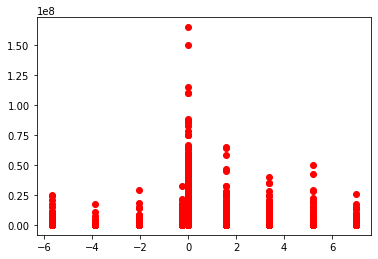

In [59]:
#посмотрим на графики зависимостей целевой переменной
plt.scatter(X['beds_new'],y,  color='red')

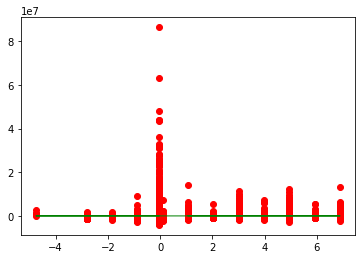

In [61]:
#посмотрим на график распределения остатков
# нарисуем картинку

zero = np.zeros(len(y_test_pred))
residuals = y_test - y_test_pred
plt.scatter(X_test['baths_new'], residuals,  color='red')
plt.plot(X_test['baths_new'],zero, color='green', linewidth=1)
#plt.scatter(X_test, y_test,  color='red')
#plt.plot(X_test, y_test_pred, color='blue', linewidth=1)


Далее идет идентификация модели: проверка на гетероскедастичность и автокоррелированность остатков.Значение Probability < 0,05, следовательно, нулевую гипотезу о равенстве дисперсий нельзя отклонить. Поэтому гетероскедастичность в построенной регрессии отсутствует. Проверку на автокоррелированность1 остатков (е – это оцененные по выборке значения отклонений) провели с помощью теста Дарбина – Уотсона (Durbin – Watson). В нашем случае статистика Дарбина – Уотсона = 1,4. Это означает, автокорреляция остатков отсутствует. Проводили расчет стоимости квартиры по построенной модели и сравнивали ее с реальной стоимостью. Для расчета были взяты пять случайных квартир из различных районов города.

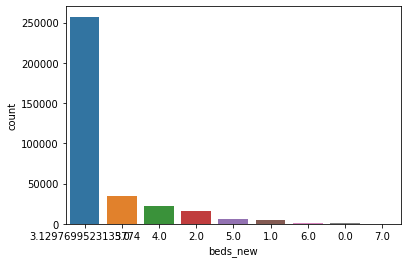

In [62]:
#посмотрим как выглядят данные

sns.countplot(df.beds_new,order=df['beds_new'].value_counts().index)



No handles with labels found to put in legend.


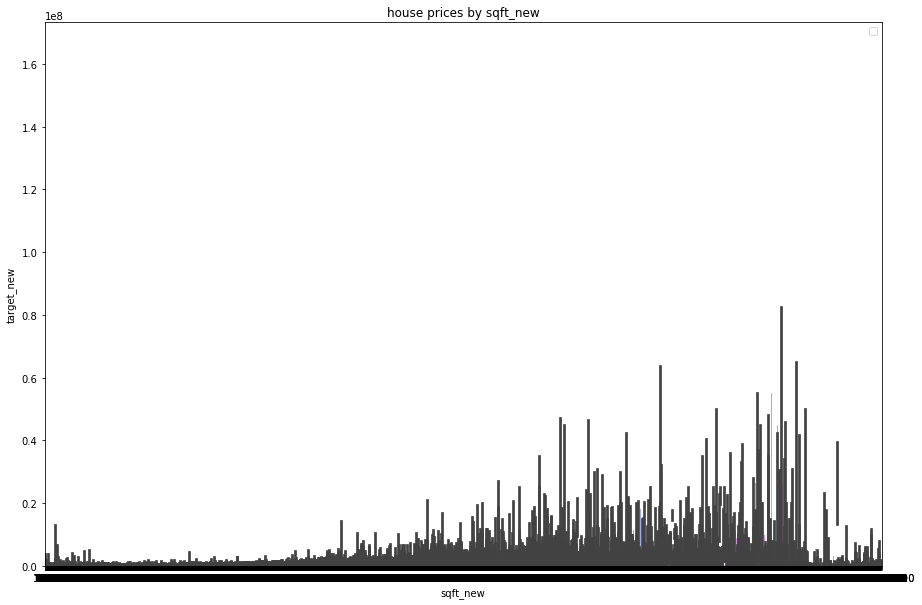

In [469]:
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(15,10))
plt.title("house prices by sqft_new")
plt.xlabel('sqft_new')
plt.ylabel('target_new')
plt.legend()
sns.barplot(x='sqft_new',y='target_new',data=df)

(array([3.65829e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.00000000e+00, 1.59195886e+08, 3.18391772e+08, 4.77587658e+08,
        6.36783544e+08, 7.95979430e+08]),
 <a list of 5 Patch objects>)

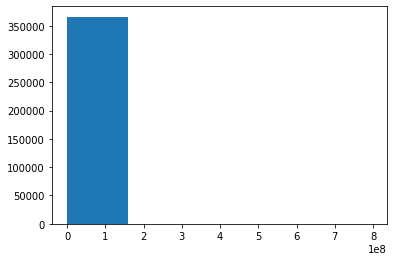

In [470]:
plt.hist('sqft_new',data=df,bins=5)

In [ ]:
#Попробовать построить модель для варианта, когда есть столбец с полиномиальным признаком

In [ ]:
factors=['beds_new','baths_new','sqft_new']

In [ ]:
#проработать далее

In [ ]:
polyfeat=PolynomialFeatures(degree=2)
xtrain_poly=polyfeat.fit_transform(train_data[features1])
xtest_poly=polyfeat.fit_transform(test_data[features1])

poly=linear_model.LinearRegression()
poly.fit(xtrain_poly,train_data['price'])
polypred=poly.predict(xtest_poly)

print('Complex Model_3')
mean_squared_error = metrics.mean_squared_error(test_data['price'], polypred)
print('Mean Squared Error (MSE) ', round(np.sqrt(mean_squared_error), 2))
print('R-squared (training) ', round(poly.score(xtrain_poly, train_data['price']), 3))
print('R-squared (testing) ', round(poly.score(xtest_poly, test_data['price']), 3))